# Project 2: Image Processing - Identifying Road Segment From Satellite Images
<hr style="clear:both">

This jupyter notebook contains our journey to train a Logistic Regression model for road segmentation in aerial images.

Authors: Mahmoud Dokmak, Romain Corbel, Guilhem
<hr style="clear:both">

I. Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
import joblib

from utils.logistic_regression import *
from utils.helpers import *

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

PATCH_SIZE = 16

plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

II. Load the data

We know that a large dataset can greatly improve the performance of a machine learning algorithm. So, we decided to see if logistic regression gives better predictions when using more data. For this, we compare results on the original dataset and on an augmented dataset created with DataAugmentation.py. Therefore, everything we do on the original dataset will also be applied to the augmented dataset.

In [2]:
root_training_dir = "dataset/training/"
root_aumg_training_dir = "dataset/TrainingInde/"

imgs, gt_imgs, n_train, files_train = load_data(root_training_dir, is_test=False)
augm_imgs, augm_gt_imgs, augm_n_train, augm_files_train = load_data(
    root_aumg_training_dir, is_test=False
)

III. Extract patches from input images

In [3]:
print("For the initial dataset:")
print("Images:")
img_patches = extract_patches(PATCH_SIZE, imgs, n_train)
print("Groundtruth:")
gt_patches = extract_patches(PATCH_SIZE, gt_imgs, n_train)
print("\nFor the augmented dataset:")
print("Images:")
augm_img_patches = extract_patches(PATCH_SIZE, augm_imgs, augm_n_train)
print("Groundtruth:")
augm_gt_patches = extract_patches(PATCH_SIZE, augm_gt_imgs, augm_n_train)

For the initial dataset:
Images:
Shape of unflattened patches : (100, 625, 16, 16, 3)
Shape of flattened patches : (62500, 16, 16, 3)

Groundtruth:
Shape of unflattened patches : (100, 625, 16, 16)
Shape of flattened patches : (62500, 16, 16)


For the augmented dataset:
Images:
Shape of unflattened patches : (800, 625, 16, 16, 3)
Shape of flattened patches : (500000, 16, 16, 3)

Groundtruth:
Shape of unflattened patches : (800, 625, 16, 16)
Shape of flattened patches : (500000, 16, 16)



IV. Feature Extraction

To build features for the logistic regression, we can use different feature extraction methods. Specifically, we can extract:
- 2 features: The mean and standard deviation (std) of the grayscale values.
- 6 features: The mean and standard deviation for the three RGB channels (3 channels × 2 features each = 6).
- 8 features: A combination of the above methods: the mean and std for the three RGB channels, along with the mean and std of the grayscale values.

In [4]:
y = label_extraction(gt_patches)
y_augm = label_extraction(augm_gt_patches)
print("For the initial dataset:")
X2d, X6d, X8d = feature_extraction(img_patches)
print("For the augmented dataset:")
X2d_augm, X6d_augm, X8d_augm = feature_extraction(augm_img_patches)

For the initial dataset:
Dimensions of the three different feature extraction methods (2D,6D,8D): (62500, 2),(62500, 6) and (62500, 8)

For the augmented dataset:
Dimensions of the three different feature extraction methods (2D,6D,8D): (500000, 2),(500000, 6) and (500000, 8)



For visualization, let's plot the distribution of road vs non-road patches (the first 1000 patchs for clarity) for the simple case of 2D features (grey mean and variance)

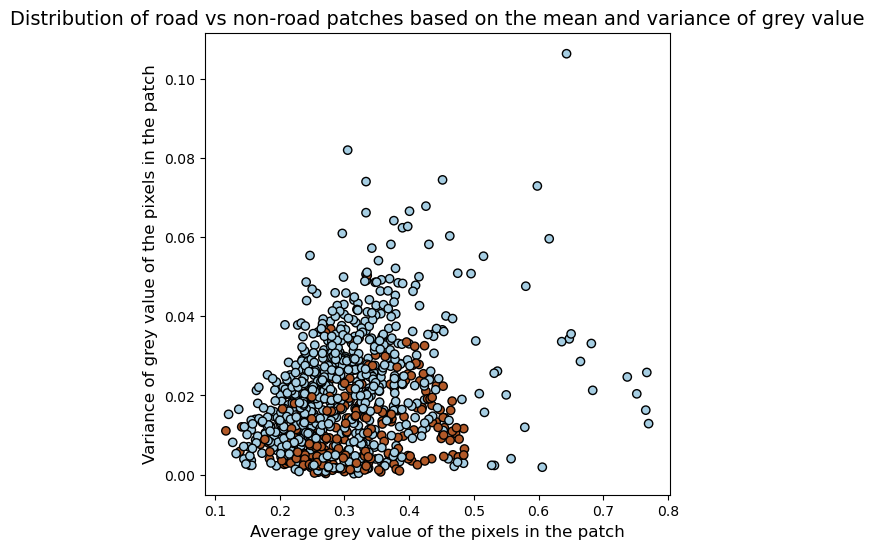

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(
    X2d[:1000, 0], X2d[:1000, 1], c=y[:1000], edgecolors="k", cmap=plt.cm.Paired
)
plt.title(
    "Distribution of road vs non-road patches based on the mean and variance of grey value"
)
plt.xlabel("Average grey value of the pixels in the patch")
plt.ylabel("Variance of grey value of the pixels in the patch")
plt.show()

In [6]:
# We split the training sets into separate train and test subsets
X_train_X2d, X_test_X2d, y_train_2d, y_test_2d = train_test_split(
    X2d, y, test_size=0.2, random_state=42
)
X_train_X6d, X_test_X6d, y_train_6d, y_test_6d = train_test_split(
    X6d, y, test_size=0.2, random_state=42
)
X_train_X8d, X_test_X8d, y_train_8d, y_test_8d = train_test_split(
    X8d, y, test_size=0.2, random_state=42
)

X_train_X2d_augm, X_test_X2d_augm, y_train_2d_augm, y_test_2d_augm = train_test_split(
    X2d_augm, y_augm, test_size=0.2, random_state=42
)
X_train_X6d_augm, X_test_X6d_augm, y_train_6d_augm, y_test_6d_augm = train_test_split(
    X6d_augm, y_augm, test_size=0.2, random_state=42
)
X_train_X8d_augm, X_test_X8d_augm, y_train_8d_augm, y_test_8d_augm = train_test_split(
    X8d_augm, y_augm, test_size=0.2, random_state=42
)

print(
    "For the initial dataset, we have computed {} features; {} for training, and {} for validation.\n".format(
        len(X2d), len(X_train_X2d), len(X_test_X2d)
    )
)
print(
    "For the augmented dataset, we have computed {} features; {} for training, and {} for validation.".format(
        len(X2d_augm), len(X_train_X2d_augm), len(X_test_X2d_augm)
    )
)

For the initial dataset, we have computed 62500 features; 50000 for training, and 12500 for validation.

For the augmented dataset, we have computed 500000 features; 400000 for training, and 100000 for validation.


In [7]:
x_train_stand_2d, x_test_stand_2d, scaler2d = standardization(X_train_X2d, X_test_X2d)
x_train_stand_6d, x_test_stand_6d, scaler6d = standardization(X_train_X6d, X_test_X6d)
x_train_stand_8d, x_test_stand_8d, scaler8d = standardization(X_train_X8d, X_test_X8d)

x_train_stand_2d_augm, x_test_stand_2d_augm, scaler2d_augm = standardization(
    X_train_X2d_augm, X_test_X2d_augm
)
x_train_stand_6d_augm, x_test_stand_6d_augm, scaler6d_augm = standardization(
    X_train_X6d_augm, X_test_X6d_augm
)
x_train_stand_8d_augm, x_test_stand_8d_augm, scaler8d_augm = standardization(
    X_train_X8d_augm, X_test_X8d_augm
)

V. Hyperparameter tuning

In [8]:
best_model_2d, best_params_2d, best_f1_2d = optimize_logistic_regression(
    x_train_stand_2d, y_train_2d
)
best_model_6d, best_params_6d, best_f1_6d = optimize_logistic_regression(
    x_train_stand_6d, y_train_6d
)
best_model_8d, best_params_8d, best_f1_8d = optimize_logistic_regression(
    x_train_stand_8d, y_train_8d
)

best_model_2d_augm, best_params_2d_augm, best_f1_2d_augm = optimize_logistic_regression(
    x_train_stand_2d_augm, y_train_2d_augm
)
best_model_6d_augm, best_params_6d_augm, best_f1_6d_augm = optimize_logistic_regression(
    x_train_stand_6d_augm, y_train_6d_augm
)
best_model_8d_augm, best_params_8d_augm, best_f1_8d_augm = optimize_logistic_regression(
    x_train_stand_8d_augm, y_train_8d_augm
)


print("For the initial data set, we have:\n")
print(
    "For 2 features:\n A best f1 score of {} with the model: \n {}".format(
        best_f1_2d, best_model_2d
    )
)
print(
    "For 6 features:\n A best f1 score of {} with the model: \n {}".format(
        best_f1_6d, best_model_6d
    )
)
print(
    "For 8 features:\n A best f1 score of {} with the model: \n {}".format(
        best_f1_8d, best_model_8d
    )
)

print("\n\n\nFor the augmented data set, we have:\n")
print(
    "For 2 features:\n A best f1 score of {} with the model: \n {}".format(
        best_f1_2d_augm, best_model_2d_augm
    )
)
print(
    "For 6 features:\n A best f1 score of {} with the model: \n {}".format(
        best_f1_6d_augm, best_model_6d_augm
    )
)
print(
    "For 8 features:\n A best f1 score of {} with the model: \n {}".format(
        best_f1_8d_augm, best_model_8d_augm
    )
)

models_dir = "./models"

# Save models
joblib.dump(best_model_2d, os.path.join(models_dir, "best_model_2d.pkl"))
joblib.dump(best_model_6d, os.path.join(models_dir, "best_model_6d.pkl"))
joblib.dump(best_model_8d, os.path.join(models_dir, "best_model_8d.pkl"))

joblib.dump(best_model_2d_augm, os.path.join(models_dir, "best_model_2d_augm.pkl"))
joblib.dump(best_model_6d_augm, os.path.join(models_dir, "best_model_6d_augm.pkl"))
joblib.dump(best_model_8d_augm, os.path.join(models_dir, "best_model_8d_augm.pkl"))

print("Models saved successfully in the /models directory.")

Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits
For the initial data set, we have:

For 2 features:
 A best f1 score of 0.44392740649160034 with the model: 
 LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')
For 6 features:
 A best f1 score of 0.46392268146768656 with the model: 
 LogisticRegression(C=2154.434690031878, class_weight='balanced', l1_ratio=0.9,
                   penalty='elasticnet', solver='saga')
For 8 features:
 A best f1 score of 0.5022861715531631 with the model: 
 LogisticRegression(class_weight='balanced', penalty='none', solver='newton-cg')



For the augmented data set, we have:

For 2 features:
 A best f

In [9]:
"""
# If the models are already saved, we can juste load them:
models_dir = "./models"

best_model_2d = joblib.load(os.path.join(models_dir, "best_model_2d.pkl"))
best_model_6d = joblib.load(os.path.join(models_dir, "best_model_6d.pkl"))
best_model_8d = joblib.load(os.path.join(models_dir, "best_model_8d.pkl"))

best_model_2d_augm = joblib.load(os.path.join(models_dir, "best_model_2d_augm.pkl"))
best_model_6d_augm = joblib.load(os.path.join(models_dir, "best_model_6d_augm.pkl"))
best_model_8d_augm = joblib.load(os.path.join(models_dir, "best_model_8d_augm.pkl"))

print("Models loaded successfully from the /models directory.")
"""

'\n# If the models are already saved, we can juste load them:\nmodels_dir = "./models"\n\nbest_model_2d = joblib.load(os.path.join(models_dir, "best_model_2d.pkl"))\nbest_model_6d = joblib.load(os.path.join(models_dir, "best_model_6d.pkl"))\nbest_model_8d = joblib.load(os.path.join(models_dir, "best_model_8d.pkl"))\n\nbest_model_2d_augm = joblib.load(os.path.join(models_dir, "best_model_2d_augm.pkl"))\nbest_model_6d_augm = joblib.load(os.path.join(models_dir, "best_model_6d_augm.pkl"))\nbest_model_8d_augm = joblib.load(os.path.join(models_dir, "best_model_8d_augm.pkl"))\n\nprint("Models loaded successfully from the /models directory.")\n'

VI. Tunning of the decision treeshold

Since predictions are not binarized within the loss function, we can train the model once for hyperparameter selection with the training set, and then tune it with multiple tresholds to maximise the F1 score on the validation set.

In [10]:
thresholds = np.arange(0.4, 0.6, 0.001)

best_treshold_2d, best_f1_2d, best_acc_2d, f1s_2d = find_best_treshold(
    best_model_2d, x_test_stand_2d, y_test_2d, thresholds
)
best_treshold_6d, best_f1_6d, best_acc_6d, f1s_6d = find_best_treshold(
    best_model_6d, x_test_stand_6d, y_test_6d, thresholds
)
best_treshold_8d, best_f1_8d, best_acc_8d, f1s_8d = find_best_treshold(
    best_model_8d, x_test_stand_8d, y_test_8d, thresholds
)

(
    best_treshold_2d_augm,
    best_f1_2d_augm,
    best_acc_2d_augm,
    f1s_2d_augm,
) = find_best_treshold(
    best_model_2d_augm, x_test_stand_2d_augm, y_test_2d_augm, thresholds
)
(
    best_treshold_6d_augm,
    best_f1_6d_augm,
    best_acc_6d_augm,
    f1s_6d_augm,
) = find_best_treshold(
    best_model_6d_augm, x_test_stand_6d_augm, y_test_6d_augm, thresholds
)
(
    best_treshold_8d_augm,
    best_f1_8d_augm,
    best_acc_8d_augm,
    f1s_8d_augm,
) = find_best_treshold(
    best_model_8d_augm, x_test_stand_8d_augm, y_test_8d_augm, thresholds
)

print("For the initial data set:")
print(
    " 2 features: treshold of {:.2f} for a f1 score of {:.2f} and an accuracy of {:.2f}".format(
        best_treshold_2d, best_f1_2d, best_acc_2d
    )
)
print(
    " 6 features: treshold of {:.2f} for a f1 score of {:.2f} and an accuracy of {:.2f}".format(
        best_treshold_6d, best_f1_6d, best_acc_6d
    )
)
print(
    " 8 features: treshold of {:.2f} for a f1 score of {:.2f} and an accuracy of {:.2f}".format(
        best_treshold_8d, best_f1_8d, best_acc_8d
    )
)
print("\n")

print("For the augmented data set:")
print(
    " 2 features: treshold of {:.2f} for a f1 score of {:.2f} and an accuracy of {:.2f}".format(
        best_treshold_2d_augm, best_f1_2d_augm, best_acc_2d_augm
    )
)
print(
    " 6 features: treshold of {:.2f} for a f1 score of {:.2f} and an accuracy of {:.2f}".format(
        best_treshold_6d_augm, best_f1_6d_augm, best_acc_6d_augm
    )
)
print(
    " 8 features: treshold of {:.2f} for a f1 score of {:.2f} and an accuracy of {:.2f}".format(
        best_treshold_8d_augm, best_f1_8d_augm, best_acc_8d_augm
    )
)
print("\n")

For the initial data set:
 2 features: treshold of 0.46 for a f1 score of 0.44 and an accuracy of 0.48
 6 features: treshold of 0.46 for a f1 score of 0.46 and an accuracy of 0.53
 8 features: treshold of 0.53 for a f1 score of 0.49 and an accuracy of 0.64


For the augmented data set:
 2 features: treshold of 0.50 for a f1 score of 0.41 and an accuracy of 0.52
 6 features: treshold of 0.49 for a f1 score of 0.43 and an accuracy of 0.53
 8 features: treshold of 0.49 for a f1 score of 0.46 and an accuracy of 0.58




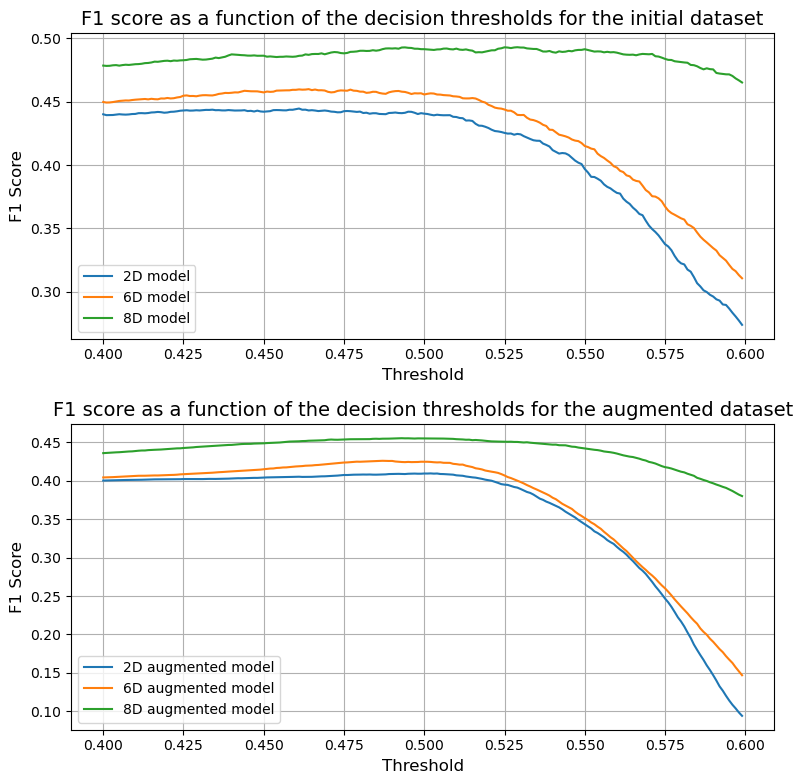

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(thresholds, f1s_2d, label="2D model")
axes[0].plot(thresholds, f1s_6d, label="6D model")
axes[0].plot(thresholds, f1s_8d, label="8D model")
axes[0].set_title(
    "F1 score as a function of the decision thresholds for the initial dataset"
)
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("F1 Score")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(thresholds, f1s_2d_augm, label="2D augmented model")
axes[1].plot(thresholds, f1s_6d_augm, label="6D augmented model")
axes[1].plot(thresholds, f1s_8d_augm, label="8D augmented model")
axes[1].set_title(
    "F1 score as a function of the decision thresholds for the augmented dataset"
)
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("F1 Score")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

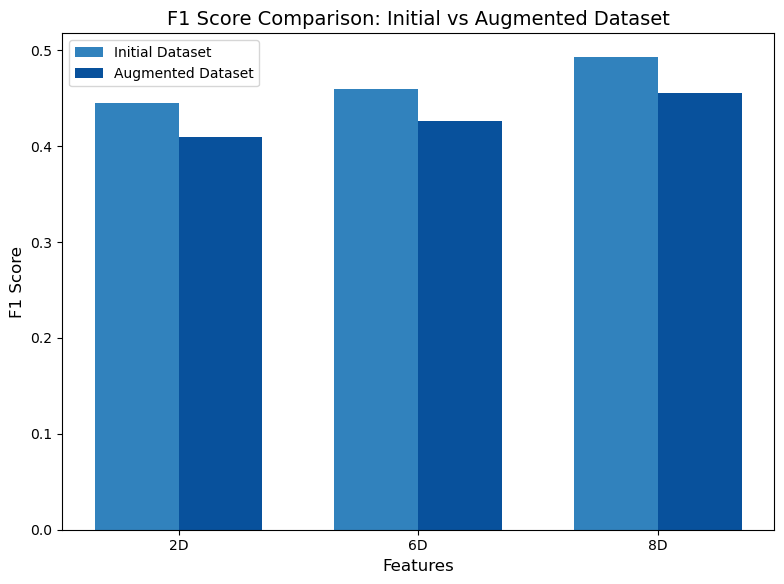

In [12]:
f1_initial = [best_f1_2d, best_f1_6d, best_f1_8d]
f1_augmented = [best_f1_2d_augm, best_f1_6d_augm, best_f1_8d_augm]

features = ["2D", "6D", "8D"]

bar_width = 0.35
x = np.arange(len(features))
# Plot
plt.figure(figsize=(8, 6))
plt.bar(x, f1_initial, width=bar_width, color="#3182bd", label="Initial Dataset")
plt.bar(
    x + bar_width,
    f1_augmented,
    color="#08519c",
    width=bar_width,
    label="Augmented Dataset",
)

# Adding labels and title
plt.xlabel("Features", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Score Comparison: Initial vs Augmented Dataset", fontsize=14)
plt.xticks(x + bar_width / 2, features)
plt.legend()

# Display plot
plt.tight_layout()
plt.show()

VII. Application of the models on the test images

In [13]:
# Load
root_test_dir = "dataset/test_set_images/"
imgs_test, n_test, folder_test = load_data(root_test_dir, is_test=True)

# Patch extraction
imgs_test_patches = extract_patches(PATCH_SIZE, imgs_test, n_test)

# Feature extraction
X2d_test, X6d_test, X8d_test = feature_extraction(imgs_test_patches)

# Standardization
X2d_test_scaled = scaler2d.transform(X2d_test)
X6d_test_scaled = scaler6d.transform(X6d_test)
X8d_test_scaled = scaler8d.transform(X8d_test)

Xi2d_augm_scaled = scaler2d_augm.transform(X2d_test)
Xi6d_augm_scaled = scaler6d_augm.transform(X6d_test)
Xi8d_augm_scaled = scaler8d_augm.transform(X8d_test)

# Prediction
Z2d_test_prediction = (
    best_model_2d.predict_proba(X2d_test_scaled)[:, 1] > best_treshold_2d
).astype(int)
Z6d_test_prediction = (
    best_model_6d.predict_proba(X6d_test_scaled)[:, 1] > best_treshold_6d
).astype(int)
Z8d_test_prediction = (
    best_model_8d.predict_proba(X8d_test_scaled)[:, 1] > best_treshold_8d
).astype(int)

Z2d_augm_test_prediction = (
    best_model_2d_augm.predict_proba(Xi2d_augm_scaled)[:, 1] > best_treshold_2d_augm
).astype(int)
Z6d_augm_test_prediction = (
    best_model_6d_augm.predict_proba(Xi6d_augm_scaled)[:, 1] > best_treshold_6d_augm
).astype(int)
Z8d_augm_test_prediction = (
    best_model_8d_augm.predict_proba(Xi8d_augm_scaled)[:, 1] > best_treshold_8d_augm
).astype(int)

# Create submission file for the best model: 8D initial dataset
w_test = imgs_test[0].shape[0]
h_test = imgs_test[0].shape[1]

sqrt_n_patches = w_test // PATCH_SIZE
array_to_submission(
    "predictions8d.csv", Z8d_test_prediction, sqrt_n_patches, PATCH_SIZE
)

print("Submission done")

Shape of unflattened patches : (50, 1444, 16, 16, 3)
Shape of flattened patches : (72200, 16, 16, 3)

Dimensions of the three different feature extraction methods (2D,6D,8D): (72200, 2),(72200, 6) and (72200, 8)

Submission done


VIII. Visualization of the 6 models for the first image of the test set

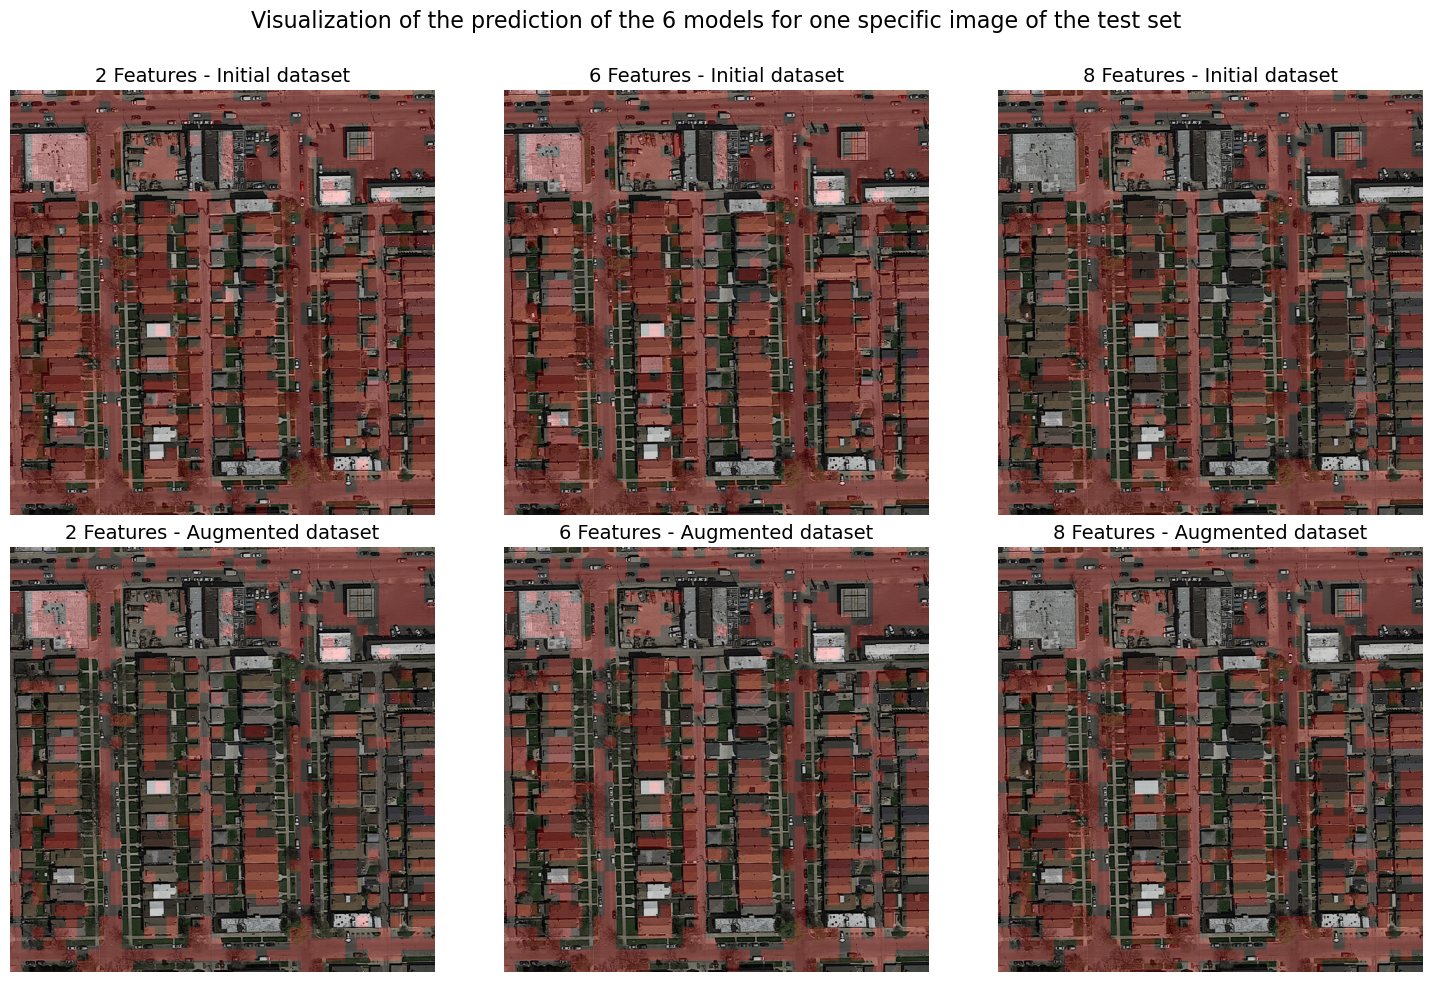

In [14]:
img_idx = 0

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(
    "Visualization of the prediction of the 6 models for one specific image of the test set",
    fontsize=16,
)

titles = [
    "2 Features - Initial dataset",
    "6 Features - Initial dataset",
    "8 Features - Initial dataset",
    "2 Features - Augmented dataset",
    "6 Features - Augmented dataset",
    "8 Features - Augmented dataset",
]

data = [
    Z2d_test_prediction[
        img_idx
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE) : (img_idx + 1)
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE)
    ],
    Z6d_test_prediction[
        img_idx
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE) : (img_idx + 1)
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE)
    ],
    Z8d_test_prediction[
        img_idx
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE) : (img_idx + 1)
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE)
    ],
    Z2d_augm_test_prediction[
        img_idx
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE) : (img_idx + 1)
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE)
    ],
    Z6d_augm_test_prediction[
        img_idx
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE) : (img_idx + 1)
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE)
    ],
    Z8d_augm_test_prediction[
        img_idx
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE) : (img_idx + 1)
        * (w_test // PATCH_SIZE)
        * (h_test // PATCH_SIZE)
    ],
]
for i, ax in enumerate(axes.ravel()):
    predicted_im = label_to_img(w_test, h_test, PATCH_SIZE, PATCH_SIZE, data[i])
    cimg = concatenate_images(imgs_test[img_idx], predicted_im)
    new_img = make_img_overlay(imgs_test[img_idx], predicted_im)

    ax.imshow(new_img, cmap="Greys_r")
    ax.set_title(titles[i])
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()